# Sales Price Prediction

### Importing the Libraries

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [20]:
salesdata = pd.read_csv("C:/Users/yuvis/Downloads/INTERNSHIPS/CODSOFT/Sales Prediction dataset.csv")

**Understanding the data**

In [21]:
salesdata.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [22]:
salesdata.shape

(200, 4)

In [23]:
salesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [24]:
salesdata.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


### Data Cleaning

**Checking Null values**

In [25]:
salesdata.isnull().sum()*100/salesdata.shape[0]

TV           0.0
Radio        0.0
Newspaper    0.0
Sales        0.0
dtype: float64

There are no NULL values in the dataset, hence it is clean.

**Outlier Analysis**

*Identify outliers based on Z-scores*

In [31]:
# Calculate the Z-scores for each column
z_scores = np.abs(stats.zscore(salesdata))

Column TV: 0 outliers
Column Radio: 0 outliers
Column Newspaper: 0 outliers
Column Sales: 0 outliers


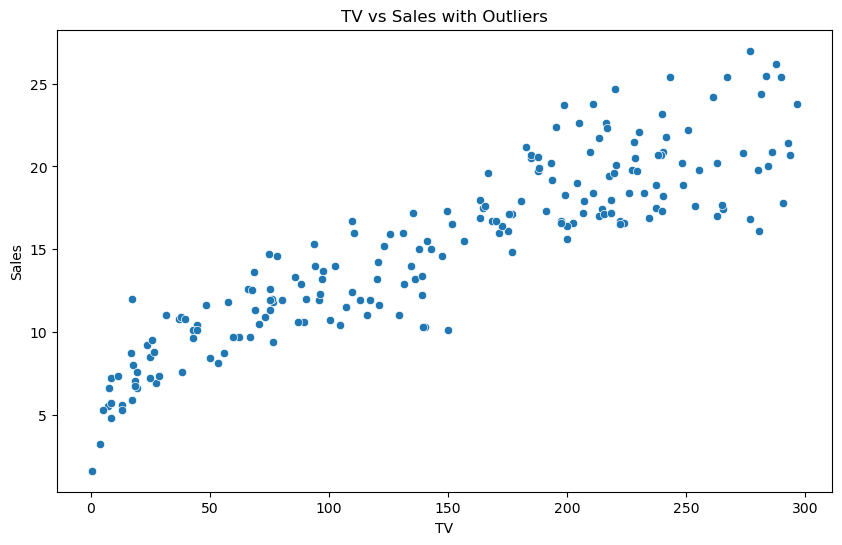

In [32]:
threshold = 3
outliers = np.where(z_scores > threshold)

# Print the number of outliers in each column
for i, col in enumerate(salesdata.columns):
    print(f"Column {col}: {np.sum(outliers[0] == i)} outliers")

# Visualize the outliers using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TV', y='Sales', data=salesdata)
plt.title("TV vs Sales with Outliers")
plt.show()

*Identify outliers using the IQR method*

Outliers using IQR method:
TV           0
Radio        0
Newspaper    2
Sales        0
dtype: int64


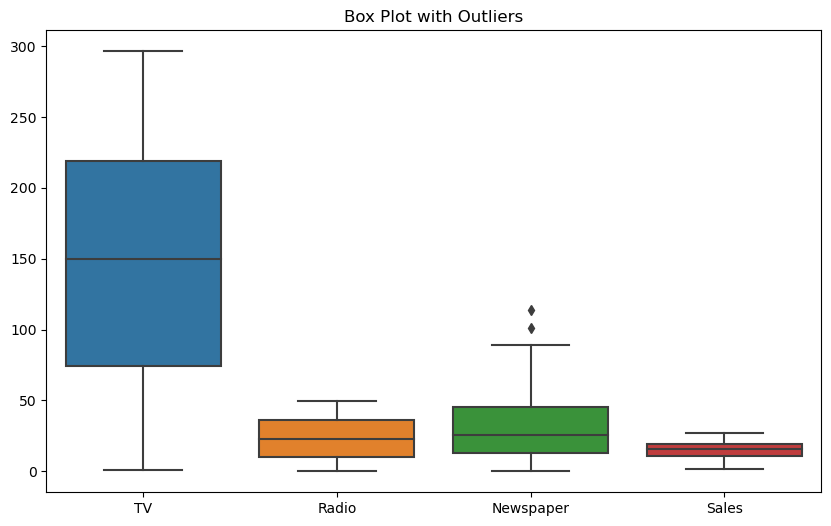

In [37]:
Q1 = salesdata.quantile(0.25)
Q3 = salesdata.quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = ((salesdata < (Q1 - 1.5 * IQR)) | (salesdata > (Q3 + 1.5 * IQR))).sum()

print("Outliers using IQR method:")
print(outliers_iqr)

# Visualize the outliers using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=salesdata)
plt.title("Box Plot with Outliers")
plt.show()

Based on the Z-score method, there are no outliers in any of the columns, but based on the IQR method, there are 2 outliers in the Newspaper column.

This is not uncommon, as the Z-score method and IQR method have different assumptions and sensitivities to outliers.

The Z-score method is more sensitive to outliers that are far away from the mean, while the IQR method is more sensitive to outliers that are far away from the median. In this case, it's possible that the 2 outliers in the Newspaper column are not extremely far away from the mean, but are still far enough away from the median to be detected by the IQR method.

In [38]:
# Investigate the outliers

outlier_rows = salesdata.loc[(salesdata['Newspaper'] < (Q1['Newspaper'] - 1.5 * IQR['Newspaper'])) | (salesdata['Newspaper'] > (Q3['Newspaper'] + 1.5 * IQR['Newspaper']))]
print(outlier_rows)

        TV  Radio  Newspaper  Sales
16    67.8   36.6      114.0   12.5
101  296.4   36.3      100.9   23.8


In [53]:
# Define the robust scaling function
def robust_scale(salesdata):
    Q1 = salesdata.quantile(0.25)
    Q3 = salesdata.quantile(0.75)
    IQR = Q3 - Q1
    return (salesdata - Q1) / IQR

## Data Visualization

### Statistical Summary

In [95]:
numerical_summary = salesdata.describe().transpose()
palette = sns.color_palette("flare", as_cmap=True)
numerical_summary.style.background_gradient(cmap=palette)

,count,mean,std,min,25%,50%,75%,max
TV,200.000000,147.042500,85.854236,0.700000,74.375000,149.750000,218.825000,296.400000
Radio,200.000000,23.264000,14.846809,0.000000,9.975000,22.900000,36.525000,49.600000
Newspaper,200.000000,30.554000,21.778621,0.300000,12.750000,25.750000,45.100000,114.000000
Sales,200.000000,15.130500,5.283892,1.600000,11.000000,16.000000,19.050000,27.000000


Sales(Target Variable)

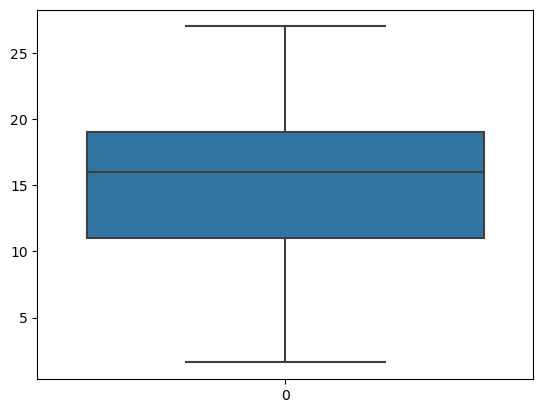

In [91]:
sns.boxplot(salesdata['Sales'])
plt.show()

How Sales are related with other variables using scatter plot

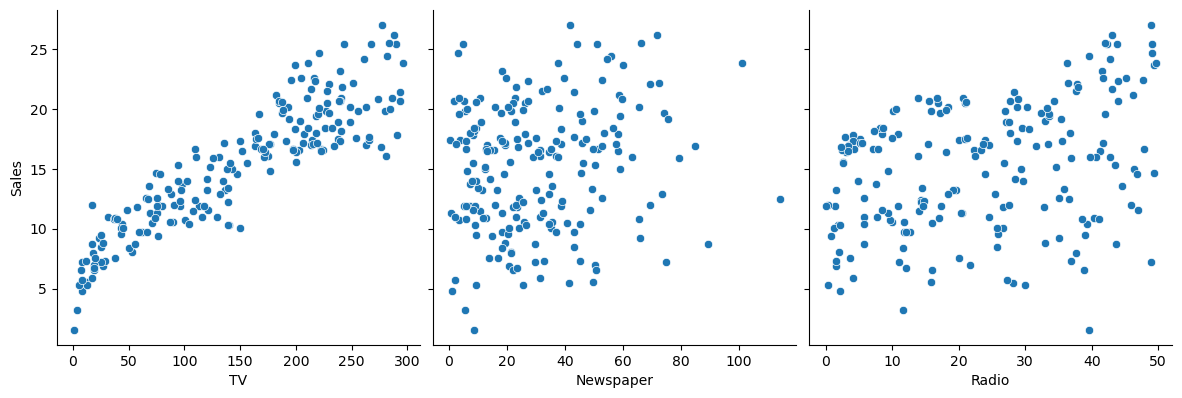

In [92]:
sns.pairplot(salesdata, x_vars=['TV', 'Newspaper', 'Radio'], y_vars='Sales', height=4, aspect=1, kind='scatter')
plt.show()

Correlation between different variables

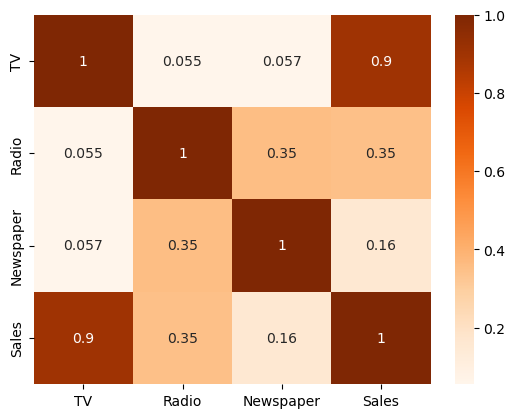

In [93]:
sns.heatmap(salesdata.corr(), cmap="Oranges", annot = True)
plt.show()

As is visible from the pairplot and the heatmap, the variable TV seems to be most correlated with Sales

## Model Building

**Define the features (X) and target (y)**

In [54]:
X = salesdata[['TV', 'Radio', 'Newspaper']]
y = salesdata['Sales']

**Splitting the dataset**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Apply robust scaling to each feature (column) separately**

In [56]:
X_train_scaled = X_train.apply(robust_scale)
X_test_scaled = X_test.apply(robust_scale)

### Random Forest Model

In [73]:
# Train a random forest regressor model on the scaled data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred_rf= rf_model.predict(X_test_scaled)

### Linear Regression Model

In [61]:
# Train a Linear Regression model on the scaled data
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred_lr = lr_model.predict(X_test_scaled)

### Decision Tree

In [62]:
# Train a Decision Tree Regressor model on the scaled data
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred_dt = dt_model.predict(X_test_scaled)

## Model Evaluation

**Random Forest**

In [90]:
print("Random Forest Regressor performance:",'\n')
print("R-squared:", rf_model.score(X_test_scaled, y_test))
print("Mean squared error:",mean_squared_error(y_test, y_pred_rf))
print("Mean Absolute Error:",mean_absolute_error(y_test, y_pred_rf))
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(y_test, y_pred_rf))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Root Mean Squared Error:", rmse_rf)
oob_score=rf_model.oob_score
print(oob_score)

Random Forest Regressor performance: 

R-squared: 0.854655142535379
Mean squared error: 4.491315974999999
Mean Absolute Error: 1.7145249999999983
Mean Absolute Percentage Error: 0.18116238125317147
Root Mean Squared Error: 2.1192725107923236
False


**Linear Regression**

In [86]:
# Evaluate the model's performance
print("Linear Regression performance:",'\n')
print("R-squared:", lr_model.score(X_test_scaled, y_test))
print("Mean squared error:",mean_squared_error(y_test, y_pred_lr))
print("Mean Absolute Error:",mean_absolute_error(y_test, y_pred_lr))
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(y_test, y_pred_lr))
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Root Mean Squared Error:", rmse_lr)

Linear Regression performance: 

R-squared: 0.8673446480646232
Mean squared error: 4.099196295690272
Mean Absolute Error: 1.618357881374117
Mean Absolute Percentage Error: 0.1591457963299881
Root Mean Squared Error: 2.0246472027714537


**Decision Tree**

In [84]:
# Evaluate the model's performance
print("Decision Tree Regressor performance:",'\n')
print("R-squared:", dt_model.score(X_test_scaled, y_test))
print("Mean squared error:",mean_squared_error(y_test, y_pred_dt))
print("Mean Absolute Error:",mean_absolute_error(y_test, y_pred_dt))
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(y_test, y_pred_dt))
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print("Root Mean Squared Error:", rmse_dt)

Decision Tree Regressor performance: 

R-squared: 0.7726375436473135
Mean squared error: 7.0257499999999995
Mean Absolute Error: 2.0275
Mean Absolute Percentage Error: 0.2155680662104281
Root Mean Squared Error: 2.650613136615753


## Final Prediction

**Ask the user to choose a Product**

In [121]:
print("Choose a product:")
print("1. TV")
print("2. Radio")
print("3. Newspaper")
product_choice = int(input("Enter the number of your chosen product: "))

if product_choice == 1:
    product = "TV"
    X = salesdata[["Radio", "Newspaper"]]
    y = salesdata["TV"]
elif product_choice == 2:
    product = "Radio"
    X = salesdata[["TV", "Newspaper"]]
    y = salesdata["Radio"]
elif product_choice == 3:
    product = "Newspaper"
    X = salesdata[["TV", "Radio"]]
    y = salesdata["Newspaper"]
else:
    print("Invalid product choice. Exiting.")
    exit()

Choose a product:
1. TV
2. Radio
3. Newspaper
Enter the number of your chosen product: 2


**Ask the user to choose a model**

In [122]:
print("Choose a model:")
print("1. Linear Regression")
print("2. Decision Tree Regressor")
print("3. Random Forest Regressor")
model_choice = int(input("Enter the number of your chosen model: "))

if model_choice == 1:
    model = LinearRegression()
    chosen_model = "Linear Regression"
elif model_choice == 2:
    model = DecisionTreeRegressor()
    chosen_model = "Decision Tree Regressor"
elif model_choice == 3:
    model = RandomForestRegressor()
    chosen_model = "Random Forest Regressor"
else:
    print("Invalid model choice. Exiting.")
    exit()

Choose a model:
1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
Enter the number of your chosen model: 1


In [123]:
# Train the model
model.fit(X_train, y_train)

LinearRegression()

**Ask the user to input new data**

In [126]:
print("Enter new data:")
if product != "TV":
    Radio = float(input("Radio advertising expenditure: "))
    Newspaper = float(input("Newspaper advertising expenditure: "))
    new_data = pd.DataFrame({
        "Radio": [Radio],
        "Newspaper": [Newspaper]
    })
elif product != "Radio":
    TV = float(input("TV advertising expenditure: "))
    Newspaper = float(input("Newspaper advertising expenditure: "))
    new_data = pd.DataFrame({
        "TV": [TV],
        "Newspaper": [Newspaper]
    })
else:
    TV = float(input("TV advertising expenditure: "))
    Radio = float(input("Radio advertising expenditure: "))
    new_data = pd.DataFrame({
        "TV": [TV],
        "Radio": [Radio]
    })

Enter new data:
Radio advertising expenditure: 123456
Newspaper advertising expenditure: 1234569


**Make a Prediction**

In [127]:
prediction = model.predict(new_data)

# Print the predicted sales
print(f"Predicted sales of {product} using {chosen_model}: {prediction[0]:.2f}")

Predicted sales of Radio using Linear Regression: 27658.58
